# Model-free Reinforcement Learning

Assume that we have the same grid world as in the previous tutorial:

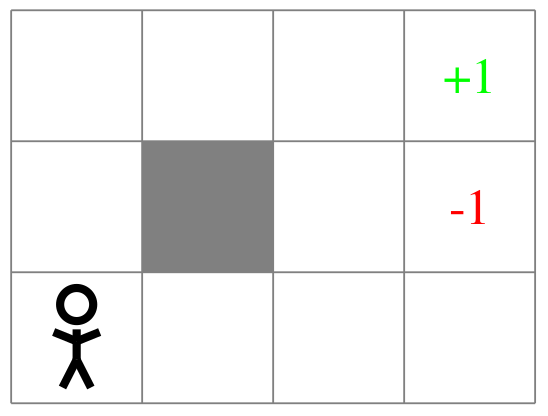

The goal of the agent whose position is at the bottom left corner is to maximize the expected future reward.
The top right (reward +1) and the middle right cell (reward -1) are terminal states.
There are four different actions the agent can choose, namely go up, down, left and right.
However, there is a chance that the agent will result in a wrong grid cell by accident.
If the action is going up, there is a chance of 0.8 that the agent moves up, a chance of 0.1 that he moves left and a chance of 0.1 that he moves right.
All other actions behave accordingly.
If the agent would bounce on a wall it stays at the current position.
Note that the agent cannot move through the grayed-out grid cell.
Assume a gamma value of $\gamma=0.9$.


### Environment Definition:

In the following, we define the described environment as an MDP.  The start (bottom left) is defined as index 0. The cell indices then increase from left to right and continue in the next row above. I.e. the cell above the start has index 4, the one with -1 reward has index 7, the cell with +1 index 11.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
np.random.seed(123)

In [ ]:
class MDP:
    """  
    Rows in _transitions correspond to actions: 0: up, 1: right, 2: left, 3: down
    - First value in brackets is the index change in the environment grid -1:'left'| +1:'up'|-4:'down'|+4:'up', 
    - Second value is the probability of going into that direction when choosing an action
    """
    _transitions = np.array([    
        [[4, 0.8], [-1, 0.1], [1, 0.1]],  #Action 0 (up) -> with prob 0.8 go up, with 0.1 go left or right
        [[1, 0.8], [-4, 0.1], [4, 0.1]],  #with prob 0.8 go right
        [[-1, 0.8], [-4, 0.1], [4, 0.1]], #with prob 0.8 go left
        [[-4, 0.8], [-1, 0.1], [1, 0.1]]  #with prob 0.8 go down
        ])
    
    def __init__(self, gamma=0.9):
        self.reward = np.zeros(3*4)
        self.reward[-1] = +1  #index -1 = 11
        #self.reward[5] = -1
        self.reward[7] = -1
        self.gamma = gamma
        
    def rewards(self, state):
        """
        Returns the reward for the given state as scalar.
        """
        return self.reward[state]
    
    def _bounces(self, state, s):
        return np.sum(
            np.abs(np.array(np.where(np.arange(12).reshape((3,4)) == state)) 
                   - np.array(np.where(np.arange(12).reshape((3,4)) == s)))
        ) > 1
    
    def transition_probs(self, state, action):
        """
        For a given state action pair, returns a list of follow states including their probabilities.
        If a state has no follow states, we return [0, 0].
        Example:
        Suppose (s, a) =  (4, 'up'). We go up to 8 with probability 0.8, left or right with probability 0.1. 
        In the latter two cases, we bump into the wall and stay at 4 Thus the output is [[8, 0.8], [4, 0.1], [4, 0.1]]
        """
        if state == 7 or state == 11:
            return np.zeros((0, 2))
        trans = MDP._transitions[action].copy()
        trans = trans.T
        trans[0,:] += state 
        trans = trans.T     #follow states
        
        #if agent bounces into wall, stay at current state
        for i, (s_new, prob) in enumerate(trans):
            if s_new < 0 or s_new >= 3*4 or s_new == 5 or self._bounces(state, s_new):
                trans[i,0] = state
        return trans
    
mdp = MDP()
#mdp.transition_probs(4, 0)

In [ ]:
def plot_environment(values):
    plt.figure()
    reshaped = values.reshape((3,4))
    ax = sns.heatmap(reshaped, annot=True)
    ax.invert_yaxis()
    ax.set_ylim(-0.1, 3.1)
    plt.show()

## Model-free

Since we use model-free reinforcement learning, we do not know the model (the underlying MDP). Hence, the agent can only learn from experience (observations and rewards) within the environment. In the following cell we define the environment the agent interacts with:

In [ ]:
class GridEnvironment:
    def __init__(self):
        self.mdp = MDP()
        self.reset()
    
    def reset(self):
        self.state = 0
        return self.state
    
    def act(self, action):
        trans = self.mdp.transition_probs(self.state, action)
        if len(trans) > 0:
            self.state = int(np.random.choice(trans[:,0], p=trans[:,1]))
        else:
            raise Exception("terminal state has no action!")
        reward = self.mdp.rewards(self.state)
        done = self.state == 7 or self.state == 11
        return self.state, reward, done
    
    def actions(self):
        return range(4)

# Q-Learning

Complete the Q-Learning algorithm in the following cell:

In [ ]:
def q_learning(env, alpha, gamma, epsilon, epochs):
    """
    Chooses an action a in state (observation) s epsilon-greedily and updates the q-values Q(s, a) by:
    Q(s, a) = Q(s, a) + alpha*(R + gamma * max_a'(Q(s', a')) - Q(s, a))
    
    alpha: learning rate
    gamma: discount factor
    epsilon: exploration rate
    
    """
        
    q_table = {}
    
    for epoch in range(epochs):
        
        done = False
        observation = env.reset()
        action = None
        
        while not done:
            # TODO
            raise Exception("Not implemented!")
        
    return q_table

In [ ]:
env = GridEnvironment()
q_table = q_learning(env, 0.01, 0.9, 0.5, 20000)

In [ ]:
# note that we do not have any action to choose in the terminal states and 
# thus we do not have any q-values for terminal states
utilities = np.asarray([np.max(q_table.get(i, [np.nan])) for i in range(12)])
print("Utility values (Q-learning)")
plot_environment(utilities)

policy = np.asarray([np.nan if state not in q_table else np.argmax(q_table[state]) for state in range(len(utilities))])
policy[5] = policy[7] = policy[11] = -1

print("Policy (Q-learning)")
plot_environment(policy)

## SARSA

Complete the SARSA algorithm in the following cell:

In [ ]:

def sarsa(env, alpha, gamma, epsilon, epochs):
    """
    Chooses an action a in state s (epsilon-greedy) and updates the q-values Q(s, a) by:
    Q(s, a) = Q(s, a) + alpha*(R + gamma * (Q(s', a')) - Q(s, a)) where a' is the next epsilon greedy acti
    
    alpha: learning rate
    gamma: discount factor
    epsilon: exploration rate
    """
    
    q_table = {}
    
    for epoch in range(epochs):
        
        done = False
        observation = env.reset()
        action = None
        
        while not done:
            # TODO
            raise Exception("Not implemented!")
        
    return q_table

In [ ]:
env = GridEnvironment()

q_table = sarsa(env, 0.01, 0.9, 0.5, 20000)

In [ ]:
utilities = np.asarray([np.max(q_table.get(i, [np.nan])) for i in range(12)])
print("Utility values (SARSA)")
plot_environment(utilities)

policy = np.asarray([np.nan if state not in q_table else np.argmax(q_table[state]) for state in range(len(utilities))])
policy[5] = policy[7] = policy[11] = -1

print("Policy (SARSA)")
plot_environment(policy)

## Question

Why is the policy from SARSA different? Is it optimal?
What do we need to change such that the policies are equal?